In [1]:
from astropy.time import Time
import astropy
import astropy.units as u
import lumos
import lumos.brdf
import lumos.brdf.library as brdf_library
import lumos.brdf.tools
import lumos.calculator
import lumos.conversions
import lumos.functions
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import EarthLocation
from lumos.brdf.library import BINOMIAL, LAMBERTIAN, PHONG
from lumos.geometry import Surface

from analysis import calculator, streakfunctions
from gen2_starlink import satellitemodels1


/Users/nayanjangid/Brightness_compare


In [2]:
# Setting up the satellite model surfaces and earth_brdf.
surfaces = satellitemodels1.get_surfaces()
earth_brdf = lumos.brdf.library.PHONG(Kd = 0.2, Ks = 0.2, n=300)

Using interpolated chassis


In [3]:
# Load the CSV file
db1 = pd.read_csv("v2mini.csv")
db=db1[db1['observing_mode'] != 'VISUAL']
db = db[~db['satellite_name'].str.contains(r'\[DTC\]', regex=True)]
db = db.reset_index(drop=True)

# Extract the observer longitude column
longitudes = db['observer_longitude_deg']
latitude = db['observer_latitude_deg']
height = db['observer_altitude_m']
uncert= db['apparent_magnitude_uncertainty']
range_km = db['range_to_sat_km_satchecker']
AP_mag_uncertainty = db['apparent_magnitude_uncertainty']
time = db['observation_time_utc']
alt = db['alt_deg_satchecker']
azi = db['az_deg_satchecker']
phase= db['phase_angle_deg_satchecker']
ob_mode=db['observing_mode']
# Adjust apparent magnitude based on observing mode
db.loc[db['observing_mode'] == 'CMOS', 'apparent_magnitude'] += 0.21
db.loc[db['observing_mode'] == 'VISUAL', 'apparent_magnitude'] += 0.02
# Then extract the updated values
apparent_magnitude = db['apparent_magnitude']


def sun_altazi(time, ob_location):
    obs_time = astropy.time.Time(time, format='jd')  
    aa_frame = astropy.coordinates.AltAz(obstime=obs_time, location=ob_location)
    sun_altaz = astropy.coordinates.get_sun(obs_time).transform_to(aa_frame)
    
    sun_alt = np.array(sun_altaz.alt.degree)  
    sun_az = np.array(sun_altaz.az.degree)
    
    # If it's a single-element array, just return the scalar values
    if sun_alt.size == 1:
        return sun_az.item(), sun_alt.item()
    else:
        return sun_az, sun_alt
    
    

In [4]:
sun_alt=[]
sun_azi=[]
for i in range(len(apparent_magnitude)):
    # Set Earth location for observer
    observer_location = astropy.coordinates.EarthLocation(
        lat=latitude[i] * u.deg,
        lon=longitudes[i] * u.deg,
        height=height[i] * u.m
    )

    # Convert ISO time to Julian Date
    t = Time(time[i], format='isot', scale='utc')
    jd = t.jd
    sun_azimuth, sun_altitude = sun_altazi(jd, observer_location)
    sun_alt.append(sun_altitude)
    sun_azi.append(sun_azimuth)

Starting solar array optimization...


Optimizing solar array orientations: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2201/2201 [14:00<00:00,  2.62it/s]



Optimization Results:
Mean absolute error: 0.5892
Median absolute error: 0.5503
RMS error: 0.7223
Max error: 2.4690
Min error: 0.0000

Results saved to 'optimized_results.csv'


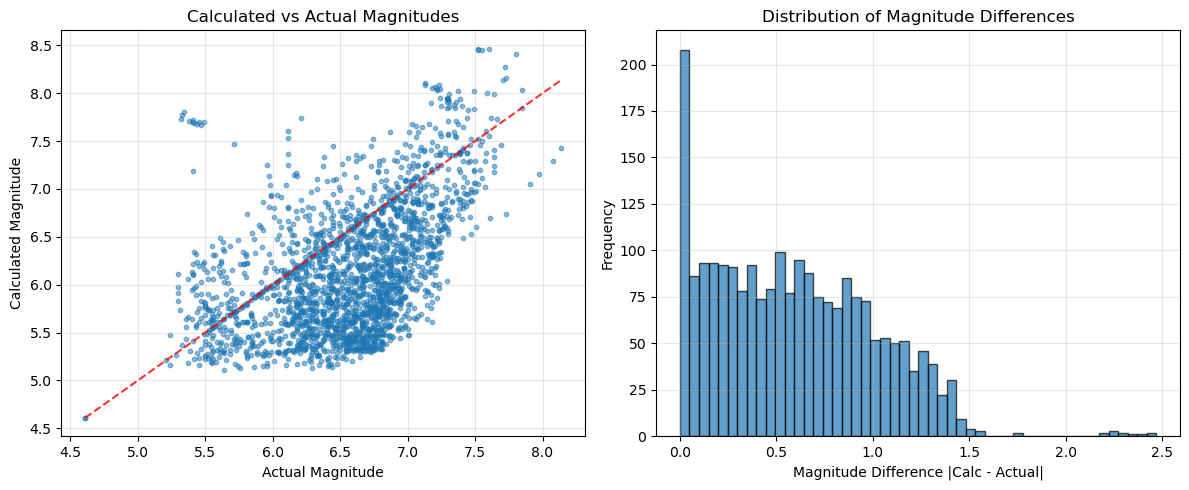


Optimization complete! Processed 2201 observations.


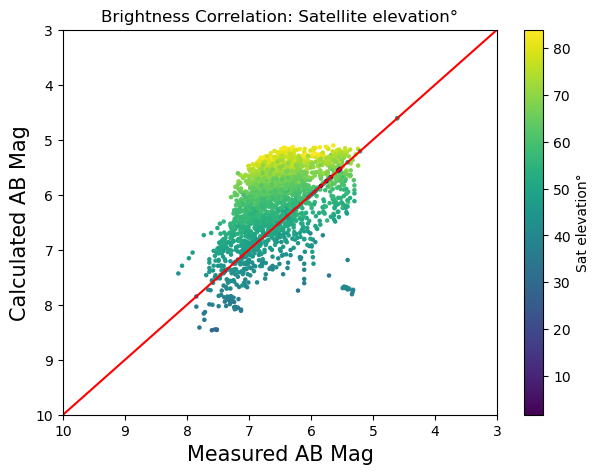

In [5]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Solar array BRDF parameters
B = np.array([[0.534, -20.409]])
C = np.array([[-527.765, 1000., -676.579, 430.596, -175.806, 57.879]])
lab_solar_array_brdf = BINOMIAL(B, C, d=3.0, l1=-3)

def rotation_matrix_xyz(theta_x, theta_y, theta_z):
    """
    Create rotation matrix from Euler angles (XYZ order)
    """
    cos_x, sin_x = np.cos(theta_x), np.sin(theta_x)
    cos_y, sin_y = np.cos(theta_y), np.sin(theta_y)
    cos_z, sin_z = np.cos(theta_z), np.sin(theta_z)
    
    R_x = np.array([[1, 0, 0],
                    [0, cos_x, -sin_x],
                    [0, sin_x, cos_x]])
    
    R_y = np.array([[cos_y, 0, sin_y],
                    [0, 1, 0],
                    [-sin_y, 0, cos_y]])
    
    R_z = np.array([[cos_z, -sin_z, 0],
                    [sin_z, cos_z, 0],
                    [0, 0, 1]])
    
    return R_z @ R_y @ R_x

def optimize_solar_array_single(idx, range_km_val, alt_val, azi_val, sun_alt_val, sun_azi_val, actual_mag, surfaces):
    """
    Optimize solar array orientation for a single observation
    """
    def objective(angles):
        theta_x, theta_y, theta_z = angles
        
        # Calculate rotated solar array normal
        initial_normal = np.array([0, 1, 0])  # Initial orientation (+Y towards sun)
        rotation_mat = rotation_matrix_xyz(theta_x, theta_y, theta_z)
        rotated_normal = rotation_mat @ initial_normal
        
        # Create surfaces with rotated solar array
        surfaces_copy = surfaces.copy()
        solar_array_surface = Surface(104.96, rotated_normal, lab_solar_array_brdf)
        surfaces_copy.append(solar_array_surface)
        
        try:
            # Calculate intensity for this single observation
            intensity = calculator.get_intensity_observer_frame(
                surfaces_copy,
                np.array([range_km_val * 1000]),  # Convert to meters
                np.array([alt_val]),
                np.array([azi_val]),
                np.array([sun_alt_val]),
                np.array([sun_azi_val]),
                include_sun=True,
                include_earthshine=True,
                earth_panel_density=151,
                earth_brdf=earth_brdf
            )
            
            # Convert to AB magnitude
            calculated_mag = lumos.conversions.intensity_to_ab_mag(intensity)[0]
            
            # Return squared difference
            return (calculated_mag - actual_mag) ** 2
            
        except Exception as e:
            # Return large penalty if calculation fails
            return 1e6
    
    # Initial guess (no rotation)
    initial_angles = [0.0, 0.0, 0.0]
    
    # Bounds for angles (allow full rotation)
    bounds = [(-np.pi, np.pi), (-np.pi, np.pi), (-np.pi, np.pi)]
    
    # Optimize
    result = minimize(
        objective,
        initial_angles,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100, 'disp': False}
    )
    return result.x, result.fun

def optimize_all_observations():
    """
    Optimize solar array orientation for all observations
    """
    n_observations = len(apparent_magnitude)
    
    # Storage for results
    optimal_angles = np.zeros((n_observations, 3))  # theta_x, theta_y, theta_z
    optimal_errors = np.zeros(n_observations)
    calculated_mags = np.zeros(n_observations)
    
    # Progress bar
    with tqdm(total=n_observations, desc="Optimizing solar array orientations") as pbar:
        for i in range(n_observations):
            try:
                # Optimize for this observation
                angles, error = optimize_solar_array_single(
                    i,
                    range_km[i],
                    alt[i],
                    azi[i],
                    sun_alt[i],
                    sun_azi[i],
                    apparent_magnitude[i],
                    surfaces
                )
                
                optimal_angles[i] = angles
                optimal_errors[i] = error
                
                # Calculate final magnitude with optimal angles
                theta_x, theta_y, theta_z = angles
                rotation_mat = rotation_matrix_xyz(theta_x, theta_y, theta_z)
                rotated_normal = rotation_mat @ np.array([0, 1, 0])
                
                surfaces_final = surfaces.copy()
                solar_array_surface = Surface(104.96, rotated_normal, lab_solar_array_brdf)
                surfaces_final.append(solar_array_surface)
                
                intensity = calculator.get_intensity_observer_frame(
                    surfaces_final,
                    np.array([range_km[i] * 1000]),
                    np.array([alt[i]]),
                    np.array([azi[i]]),
                    np.array([sun_alt[i]]),
                    np.array([sun_azi[i]]),
                    include_sun=True,
                    include_earthshine=True,
                    earth_panel_density=151,
                    earth_brdf=earth_brdf
                )
                
                calculated_mags[i] = lumos.conversions.intensity_to_ab_mag(intensity)[0]
                
            except Exception as e:
                print(f"Error in observation {i}: {e}")
                optimal_angles[i] = [0, 0, 0]
                optimal_errors[i] = 1e6
                calculated_mags[i] = np.nan
            
            pbar.update(1)
    
    return optimal_angles, optimal_errors, calculated_mags

# Run the optimization
print("Starting solar array optimization...")
optimal_angles, optimal_errors, calculated_mags = optimize_all_observations()

# Add results to dataframe
db['optimal_theta_x'] = optimal_angles[:, 0]
db['optimal_theta_y'] = optimal_angles[:, 1]
db['optimal_theta_z'] = optimal_angles[:, 2]
db['optimization_error'] = optimal_errors
db['calculated_magnitude'] = calculated_mags
db['magnitude_difference'] = np.abs(calculated_mags - apparent_magnitude)

# Print summary statistics
print("\nOptimization Results:")
print(f"Mean absolute error: {np.nanmean(db['magnitude_difference']):.4f}")
print(f"Median absolute error: {np.nanmedian(db['magnitude_difference']):.4f}")
print(f"RMS error: {np.sqrt(np.nanmean(db['magnitude_difference']**2)):.4f}")
print(f"Max error: {np.nanmax(db['magnitude_difference']):.4f}")
print(f"Min error: {np.nanmin(db['magnitude_difference']):.4f}")

# Save results
db.to_csv('optimized_results.csv', index=False)
print("\nResults saved to 'optimized_results.csv'")

# Optional: Plot results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot calculated vs actual magnitudes
ax1.scatter(apparent_magnitude, calculated_mags, alpha=0.5, s=10)
ax1.plot([apparent_magnitude.min(), apparent_magnitude.max()], 
         [apparent_magnitude.min(), apparent_magnitude.max()], 'r--', alpha=0.8)
ax1.set_xlabel('Actual Magnitude')
ax1.set_ylabel('Calculated Magnitude')
ax1.set_title('Calculated vs Actual Magnitudes')
ax1.grid(True, alpha=0.3)

# Plot error distribution
ax2.hist(db['magnitude_difference'], bins=50, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Magnitude Difference |Calc - Actual|')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Magnitude Differences')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nOptimization complete! Processed {len(apparent_magnitude)} observations.")

# results_df.to_csv('solar_array_optimization_results.csv', index=False)
plt.figure(figsize=(7,5))
plt.scatter(apparent_magnitude,  calculated_mags, s=5, c=alt, cmap="viridis")
plt.plot([12, 3], [12, 3], 'r-')
plt.xlabel('Measured AB Mag', fontsize=15)
plt.ylabel('Calculated AB Mag', fontsize=15)
plt.xlim(10,3)
plt.ylim(10,3)
plt.title("Brightness Correlation: Satellite elevation°")
cbar = plt.colorbar()
cbar.set_label('Sat elevation°')
plt.show()